In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F # capas para aplicar funciones

In [ ]:
class Net(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(Net, self).__init__()

    self.num_channels = num_channels
    self.num_classes = num_classes

    # Definición de las capas de convolución, es aquí donde se aplican los filtros
    self.conv1 = nn.Conv2d(
        in_channels=3, out_channels=self.num_channels, 
        kernel_size=3, stride=1, padding=1
    )
    self.conv2 = nn.Conv2d(
        in_channels=self.num_channels, out_channels=self.num_channels*2, 
        kernel_size=3, stride=1, padding=1
    )
    self.conv3 = nn.Conv2d(
        in_channels=self.num_channels*2, out_channels=self.num_channels*4, 
        kernel_size=3, stride=1, padding=1
    )

    # Fully connected
    self.fc1 = nn.Linear(in_features=self.num_channels*4*8*8, out_features=self.num_channels*4)
    self.fc2 = nn.Linear(in_features=self.num_channels*4, out_features=self.num_classes)

  # Flujo de información hacia adelante (predicción)
  def forward(self, x):
    # Inicialmente el tensor tiene dimensión (3, 64, 64)
    x = self.conv1(x) # ahora dim = (num_channels, 64, 64)
    x = F.relu(F.max_pool2d(x, 2)) # dim = (num_channels, 32, 32)
    x = self.conv2(x) # ahora dim = (num_channels * 2, 32, 32)
    x = F.relu(F.max_pool2d(x, 2)) # dim = (num_channels * 2, 16, 16)
    x = self.conv3(x) # ahora dim = (num_channels * 4, 16, 16)
    x = F.relu(F.max_pool2d(x, 2)) # dim = (num_channels * 4, 8, 8)

    # Flatten
    x = x.view(-1, self.num_channels*4*8*8)

    # Fully connected
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    # Classificación probabilística multiclase
    y = F.log_softmax(x, dim=1)

    return y

## Cargar datos

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Ver la estructura del dataset
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [ ]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

from plot_helpers import imshow

In [ ]:
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDatasets(Dataset):
  def __init__(self, base_dir, split='train', transform=None):
    path = os.path.join(base_dir, '{}_signs'.format(split))
    files = os.listdir(path)

    self.filenames = [os.path.join(path, f) for f in files if f.endswith('.jpg')]
    # classes
    self.targets = [int(f[0]) for f in files]
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])

    if self.transform:
      image = self.transform(image)

    
    return image, self.targets[idx]

In [ ]:
# Instanciar la clase para cargar el dataset de entrenamiento
dataset_path = '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

signs = SIGNSDatasets(dataset_path, split='train')

In [ ]:
# Probar los métodos que se sobreescribieron

# Longitud
print(len(signs))
print('-'*42)


864
------------------------------------------


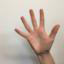

In [ ]:
# Get Item
signs[42][0]

#### Cargar el dataset de entrenamiento con la transformación a tensor

In [ ]:
import torchvision.transforms as transforms

dataset_path = '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

traindataset = SIGNSDatasets(dataset_path, split='train', transform=transforms.ToTensor())

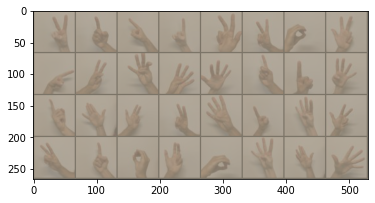

tensor([2, 1, 1, 1, 3, 2, 0, 3, 1, 2, 4, 4, 5, 1, 1, 4, 1, 5, 3, 2, 4, 1, 4, 3,
        2, 1, 0, 3, 0, 4, 5, 5])


In [ ]:
from torchvision.utils import make_grid

dataloader = DataLoader(traindataset, batch_size=32)

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [ ]:
import torch.optim as optim

device = torch.device('cuda')

# Instanciar nuestra Red Neuronal Convolucional
loss_fn = nn.NLLLoss()

net = Net(num_channels=32, num_classes=6).to(device)

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)


#### Función helper para mostrar métricas durante el entrenamiento

In [ ]:
class RunningMetric():
  def __init__(self):
    self.sum = 0
    self.size = 0

  def update(self, val, size):
    self.sum += val
    self.size += size

  def __call__(self):
    return self.sum / float(self.size)


## ENTRENAMIENTO

In [ ]:
num_epochs = 100

In [ ]:
# Iterar las épocas del entrenamiento

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch + 1, num_epochs))
  print('-'*14)

  running_loss_metric = RunningMetric() 
  running_acc_metric = RunningMetric()

  for inputs, targets  in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_fn(outputs, targets)

    # Backpropagation
    loss.backward()
    optimizer.step()

    batch_size = inputs.size()[0]

    # Actualizar métricas
    running_loss_metric.update(loss.item()*batch_size, batch_size)
    running_acc_metric.update(torch.sum(preds == targets).float(), batch_size)
  

  print('Loss: {:.4f}, Acc: {:.4f} '.format(running_loss_metric(), running_acc_metric()))




Epoch 1/100
--------------
Loss: 1.7926, Acc: 0.1644 
Epoch 2/100
--------------
Loss: 1.7918, Acc: 0.1644 
Epoch 3/100
--------------
Loss: 1.7913, Acc: 0.1690 
Epoch 4/100
--------------
Loss: 1.7908, Acc: 0.1782 
Epoch 5/100
--------------
Loss: 1.7904, Acc: 0.1725 
Epoch 6/100
--------------
Loss: 1.7900, Acc: 0.1725 
Epoch 7/100
--------------
Loss: 1.7895, Acc: 0.1725 
Epoch 8/100
--------------
Loss: 1.7891, Acc: 0.1725 
Epoch 9/100
--------------
Loss: 1.7886, Acc: 0.1725 
Epoch 10/100
--------------
Loss: 1.7881, Acc: 0.1736 
Epoch 11/100
--------------
Loss: 1.7875, Acc: 0.1748 
Epoch 12/100
--------------
Loss: 1.7869, Acc: 0.1771 
Epoch 13/100
--------------
Loss: 1.7863, Acc: 0.1887 
Epoch 14/100
--------------
Loss: 1.7855, Acc: 0.1991 
Epoch 15/100
--------------
Loss: 1.7847, Acc: 0.2106 
Epoch 16/100
--------------
Loss: 1.7838, Acc: 0.2315 
Epoch 17/100
--------------
Loss: 1.7828, Acc: 0.2442 
Epoch 18/100
--------------
Loss: 1.7816, Acc: 0.2569 
Epoch 19/100
------

### SALVANDO EL MODELO

In [ ]:
model_path = '/gdrive/My Drive/dl-pytorch/datasets/model.pt'

#Para salvar el modelo
torch.save(net.state_dict(), model_path)

model = Net(num_channels=32, num_classes=6).to(device)

#Para cargar el modelo
model.load_state_dict(torch.load(model_path))
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
